# Component 2: ML-Powered App Discovery: Prediction and Hybrid Recommender

This notebook executes the final two analytical components of the project: the Predictive Classifier to assess app quality drivers, and the Hybrid Recommender that synthesizes all results into a final, actionable ranking.

Assumptions:

The source data (anguage_apps_category.csv) has been generated and already contains the finalized cluster_label and category columns from Notebook 01.

Artifact Dependency: The fitted NLP models are saved locally using joblib (best practice).



## 1. Setup, Data Loading, and Final Feature Check

We load the necessary libraries and the final enriched DataFrame.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate # For clean table output
import joblib # Library for loading serialized models

# ML Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline 
from xgboost import XGBClassifier 

# NLP Libraries (for minimal recreation of vectorizer objects)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import nltk
# Ensure NLTK resources are available if running this notebook standalone
try:
    stopwords.words('english')
    WordNetLemmatizer()
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')

In [2]:

# --- Load the Final Data ---
FILE_PATH = 'language_apps_category.csv' 
df = pd.read_csv(FILE_PATH)
df.head()

,title,description,category,descriptionHTML,summary,installs,minInstalls,realInstalls,score,ratings,...,max_iap_price,languages_offered,hdbscan_label,P_Comprehensive_Skill_Builder,P_Conversation_&_Fluency,P_Exam_Preparation,P_Fun_&_Specialized_Learning,P_Language_Exchange,P_Vocabulary_&_Flashcard,category_multi
0,Duolingo: Language Lessons,Learn a new language with the world‚Äôs most-d...,Fun & Specialized Learning,Learn a new language with the world‚Äôs most-d...,"Learn Spanish, French, German, English, Math, ...","500,000,000+",500000000,798147205,4.567638,40018826.0,...,239.99,"spanish,french,german,japanese,korean,chinese,...",-1,0.049214,0.041178,0.014958,0.865502,0.011063,0.018085,Fun & Specialized Learning
1,Busuu: Learn & Speak Languages,Learn Spanish with language learning designed ...,Conversation & Fluency,Learn Spanish with language learning designed ...,"Learn Languages Fast - Learn Spanish, Japanese...","50,000,000+",50000000,52244753,4.659640,1054466.0,...,169.99,"spanish,french,german,japanese,korean,chinese,...",-1,0.135073,0.718685,0.018185,0.063874,0.039104,0.025080,Conversation & Fluency
2,Speak: Language Learning,Get ready to take your language skills to the ...,Conversation & Fluency,Get ready to take your language skills to the ...,"Reach fluency in Spanish, French, English, and...","5,000,000+",5000000,8902185,4.668526,98601.0,...,349.99,"spanish,french,japanese,korean,italian,english",-1,0.023264,0.907755,0.008222,0.018616,0.031073,0.011070,Conversation & Fluency
3,Lingo Legend Language Learning,Learn a language while playing language learni...,LANGUAGE_LEARNING,Learn a language while playing language learni...,"Learn a language playing a game! Spanish, Fren...","100,000+",100000,345318,4.757576,8450.0,...,149.99,"spanish,french,german,japanese,korean,chinese,...",-1,0.200125,0.063867,0.030334,0.514969,0.096528,0.094177,Fun & Specialized Learning
4,Falou - Fast language learning,Want to learn a language really fast? Don't ha...,LANGUAGE_LEARNING,Want to learn a language really fast? Don&#39;...,Want to learn English? Learn French or learn S...,"10,000,000+",10000000,12150516,4.726343,836163.0,...,149.99,"spanish,french,german,japanese,korean,chinese,...",-1,0.369912,0.150039,0.018274,0.364876,0.040510,0.056389,"Comprehensive Skill Builder, Fun & Specialized..."


## 2. Component B: Final Recommender System (Hybrid Logic)

### 2.0. Predictive Model Fit (Deriving Feature Weights for FAS)
In this initial step, we train a high-performance Logistic Regression model on the full dataset to extract feature weights, which will be used to compute the Feature Alignment Score (FAS). Logistic Regression was chosen for its interpretable coefficients, which can be directly leveraged for FAS.

I experimented with XGBoost for prediction due to its strong performance on structured data. However, because FAS requires directional feature weights, I ultimately chose Logistic Regression for this step. This allows us to combine interpretability with stable predictive performance.

In [3]:
df.columns

Index(['title', 'description', 'category', 'descriptionHTML', 'summary',
       'installs', 'minInstalls', 'realInstalls', 'score', 'ratings',
       'reviews', 'histogram', 'price', 'free', 'currency', 'sale', 'saleTime',
       'originalPrice', 'saleText', 'offersIAP', 'inAppProductPrice',
       'developer', 'developerId', 'developerEmail', 'developerWebsite',
       'developerAddress', 'privacyPolicy', 'genre', 'genreId', 'categories',
       'icon', 'headerImage', 'screenshots', 'video', 'videoImage',
       'contentRating', 'contentRatingDescription', 'adSupported',
       'containsAds', 'released', 'lastUpdatedOn', 'updated', 'version',
       'comments', 'appId', 'url', 'category.1', 'full_text', 'cleaned_text',
       'is_high_popularity', 'is_developer', 'has_ads', 'is_paid',
       'min_iap_price', 'max_iap_price', 'languages_offered', 'hdbscan_label',
       'P_Comprehensive_Skill_Builder', 'P_Conversation_&_Fluency',
       'P_Exam_Preparation', 'P_Fun_&_Specialized_Learni

In [4]:
categories = [c for c in df['category'].unique() if c!='LANGUAGE_LEARNING']
# Create one new binary column for every core category
multi_label_cols  = []
for category in categories:
    col_name = f'is_{category}'
    # Check if the category name exists in the comma-separated string
    df[col_name] = df['category_multi'].str.contains(category, case=False, na=False)
    multi_label_cols.append(col_name)

# Convert boolean columns to integer (1/0)
df[multi_label_cols] = df[multi_label_cols].astype(int)
df[['has_ads', 'is_developer', 'is_paid']] = df[['has_ads', 'is_developer', 'is_paid']].astype(int)

df['reviews_per_install'] = df['reviews'] / (df['realInstalls'] + 1)  # +1 to avoid divide-by-zero
df['ratings_per_install'] = df['ratings'] / (df['realInstalls'] + 1)
df['iap_range'] = df['max_iap_price'] - df['min_iap_price']


In [5]:
#text_feature = 'description'

numerical_features_c = [
    'min_iap_price', 'max_iap_price', 'reviews_per_install'
]

prob_features = [c for c in df.columns if c.startswith('P_')]
numerical_features_c += prob_features

categorical_features_c = ['genre']
boolean_features_c = ['has_ads', 'is_developer', 'is_paid'] 
feature_names = numerical_features_c + categorical_features_c + boolean_features_c


In [6]:
# text_pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer(
#         max_features=800,
#         ngram_range=(1, 2),
#         min_df=3,
#         stop_words='english'
#     ))
# ])

numerical_pipeline_c = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor_c = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline_c, numerical_features_c),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_c),
    ],
    remainder='passthrough'
)
clf = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,          
    max_iter=5000,
    class_weight='balanced'
)

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor_c),
    ('clf', clf)
])


In [7]:
X = df[feature_names]
y = df['is_high_popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

logreg_pipeline.fit(X_train, y_train)

print("Train F1:", f1_score(y_train, logreg_pipeline.predict(X_train)))
print("Test F1:", f1_score(y_test, logreg_pipeline.predict(X_test)))


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(logreg_pipeline, X, y, cv=cv, scoring='f1')
print("Mean CV F1:", cv_scores.mean())
print("Std CV:", cv_scores.std())

Train F1: 0.6601466992665037
Test F1: 0.6538461538461539
Mean CV F1: 0.623389473387448
Std CV: 0.0429846437641244


While these scores are not perfect, maximizing F1 is not the main priority for FAS at this stage. Additional features and improvements can be explored in future iterations.

In [8]:
print(clf.coef_.shape)

(1, 29)


In [9]:
 # replace xgb_pipeline_c with your LR pipeline

# Get feature names after preprocessing
cat_names = list(logreg_pipeline['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features_c))
feature_names_c = numerical_features_c + cat_names + boolean_features_c

# Extract coefficients (flatten if needed)
coef_values = clf.coef_.flatten()  # shape (1, n_features) → flatten to (n_features,)

# Map to feature names
COEFFICIENT_MAP = pd.Series(coef_values, index=feature_names_c)

# Create a sorted DataFrame for display
coefficients = (COEFFICIENT_MAP
                .reset_index()
                .rename(columns={'index': 'Feature', 0: 'Coefficient'})
                .sort_values(by='Coefficient', ascending=False))

coefficients.head(10)

,Feature,Coefficient
21,genre_Productivity,1.024811
26,has_ads,0.714327
1,max_iap_price,0.480684
16,genre_Entertainment,0.346639
27,is_developer,0.334381
18,genre_Medical,0.301501
5,P_Exam_Preparation,0.227291
10,genre_Books & Reference,0.175800
3,P_Comprehensive_Skill_Builder,0.050565
4,P_Conversation_&_Fluency,0.048242


### 2.1. Recommender Prep: Adjusted Quality Score

Looking at the following scatter plot, you can see there are more than 4.5 'score' apps 10 ratings and 10^6 ratings. I use the **Bayesian Average** to adjust the raw `score` based on the number of ratings, making high scores more reliable.

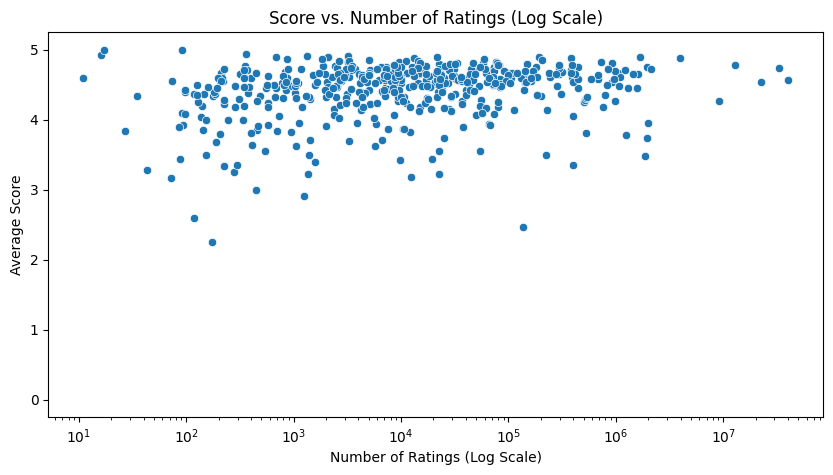

In [10]:
# Correlation between Score and Number of Ratings
plt.figure(figsize=(10, 5))
sns.scatterplot(x='ratings', y='score', data=df)
plt.xscale('log') # Use log scale for clarity due to huge range of ratings
plt.title('Score vs. Number of Ratings (Log Scale)')
plt.xlabel('Number of Ratings (Log Scale)')
plt.ylabel('Average Score')
plt.show()

*Apps with few ratings are extremely sensitive to individual reviews (High Volatility), while as the number of ratings increases, the average score is less subjective to individual review. High-quality apps require a large volume of ratings to reach a stable, high score. We can be confident in the score for highly-rated apps.

In [11]:
# Calculate C (Confidence Threshold) and m (Global Mean Score)
C = df['ratings'].quantile(0.75)
m = df['score'].mean()

# Calculate Bayesian Adjusted Score (BAS)
def bayesian_average(row, C, m):
    """Calculates the Bayesian Average Score (BAS), which adjusts raw score (R) 
    toward the global mean (m) based on the number of ratings (v) relative to 
    the confidence threshold (C)."""
    v = row['ratings'] # v = number of scores
    R = row['score']   # R = raw average score
    return (v * R + C * m) / (v + C)

df['adjusted_score'] = df.apply(bayesian_average, args=(C, m), axis=1)

print(f"Global Mean Score (m): {m:.2f}")
print(f"Confidence Threshold (C - 75th Percentile Ratings): {C:.0f}")


Global Mean Score (m): 4.16
Confidence Threshold (C - 75th Percentile Ratings): 54456


### 2.2. Final Recommender Logic (Two-Factor Hybrid)

The final ranking is a two-factor weighted combination:

1. **Adjusted Quality** ($w_1$)

2. **Feature Alignment Score (FAS)** ($w_2$) - Derived from the predictive model coefficients.

In [12]:
# --- OPTIMIZED WEIGHTS (We introduce a 3rd weight W3 for FAS) ---
# We prioritize Relevance most, then Quality, then Feature Alignment
W1_QUALITY = 0.60   # Adjusted Quality (BAS)
W2_PREDICTIVE = 0.40 # Feature Alignment Score (FAS)

def calculate_feature_alignment_score(row, preprocessor_c, coefficient_map):
    """Calculates the Feature Alignment Score (FAS) using the XGBoost feature importances.
    
    This function measures the cumulative predictive power of an app's features on its predicted success score.
    """
    
    # 1. Create input DataFrame copy
    input_df = row[feature_names].to_frame().T.copy()
    
    # 2. Transform the input using the fitted preprocessor
    # The preprocessor is the fitted object *from the pipeline*
    processed_features = preprocessor_c.transform(input_df)
    
    # 3. Calculate score: Dot product of processed features and coefficients (XGBoost Importances)
    score = np.dot(processed_features.flatten(), coefficient_map.values)
    
    return score

# Calculate FAS for every app in the DataFrame 
# NOTE: Using xgb_pipeline_c['preprocessor'] and COEFFICIENT_MAP defined in Section 2.0
df['raw_fas'] = df.apply(lambda row: calculate_feature_alignment_score(row, logreg_pipeline['preprocessor'], COEFFICIENT_MAP), axis=1)

# Normalize FAS globally to scale it between 0 and 1
fas_min = df['raw_fas'].min()
fas_max = df['raw_fas'].max()

if fas_max != fas_min:
    df['normalized_fas'] = (df['raw_fas'] - fas_min) / (fas_max - fas_min)
else:
    df['normalized_fas'] = 0.0 

In [13]:
def get_recommendations(target_style, target_language=None, num_recommendations=5):
    """Generates recommendations using the TwoFACTOR Hybrid Score."""

    # 1. Base Filter: Language
    if target_language:
        filtered_df = df[df['languages_offered'].str.contains(target_language, case=False, na=False)].copy()
        if filtered_df.empty:
            print(f"No apps found that teach '{target_language}'.")
            return
    else:
        filtered_df = df.copy()

    # 2. Secondary Filter: Learning Style
    filtered_df = filtered_df[filtered_df['category'] == target_style].copy()
    if filtered_df.empty:
        print(f"No apps found for '{target_language}' in the '{target_style}' style.")
        return
    
    # 4. Create Final Weighted Rank (Hybrid Model)
    
    # Normalize scores
    adj_max = filtered_df['adjusted_score'].max()
   
    filtered_df['normalized_adjusted_score'] = filtered_df['adjusted_score'] / max(adj_max, 1e-9)
    # The FAS is already normalized globally, but we rescale relative to the max in the filtered group
    filtered_df['normalized_fas_local'] = filtered_df['normalized_fas'] / max(filtered_df['normalized_fas'].max(), 1e-9) 

    # FINAL Two-FACTOR RANKING
    filtered_df['final_rank_score'] = (
        W1_QUALITY * filtered_df['normalized_adjusted_score'] +
        W2_PREDICTIVE * filtered_df['normalized_fas_local']
    )
    
    # 5. Output Top Recommendations
    recommendations = filtered_df.sort_values(by='final_rank_score', ascending=False).head(num_recommendations)
    
    if target_language:
        print(f"\n--- Top {num_recommendations} Recommendations for: {target_language.capitalize()} in the '{target_style}' Style ---")
    else:   
        print(f"\n--- Top {num_recommendations} Recommendations for: All Languages in the '{target_style}' Style ---")
    print(f"--- Hybrid Weights: Quality={W1_QUALITY}, Predictive={W2_PREDICTIVE} ---")
    
    final_output = recommendations[[
        'title',  
        'final_rank_score',
        'normalized_adjusted_score', 
        'normalized_fas_local', # Show the FAS contribution
        'normalized_fas'
    ]]
    
    print(tabulate(final_output, headers='keys', tablefmt='pipe', showindex=False))


# --- DEMO THE FINAL RECS ---
# I select a few styles to demonstrate the effectiveness of the hybrid model.
get_recommendations(target_style='Fun & Specialized Learning', target_language='chinese', num_recommendations=5)
get_recommendations(target_style='Conversation & Fluency', target_language='spanish', num_recommendations=5)
get_recommendations(target_style='LLM', num_recommendations=5)


--- Top 5 Recommendations for: Chinese in the 'Fun & Specialized Learning' Style ---
--- Hybrid Weights: Quality=0.6, Predictive=0.4 ---
| title                         |   final_rank_score |   normalized_adjusted_score |   normalized_fas_local |   normalized_fas |
|:------------------------------|-------------------:|----------------------------:|-----------------------:|-----------------:|
| Duolingo: Language Lessons    |           0.986015 |                    1        |               0.965039 |         0.829234 |
| LingoDeer - Learn Languages   |           0.95754  |                    0.968812 |               0.940631 |         0.808261 |
| Beelinguapp Language Learning |           0.948005 |                    0.913342 |               1        |         0.859275 |
| Readle: Learn Languages Daily |           0.919271 |                    0.92305  |               0.913603 |         0.785036 |

--- Top 5 Recommendations for: Spanish in the 'Conversation & Fluency' Style ---
--- Hy